In [1]:
import numpy as np
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
import ccdproc as ccd
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
import reproject as r
import pandas as pd

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

input_fits_file = 'HW_12/tekfiles/tek084.fits'
output_fits_file = 'HW_12/wcs_updated1.fits'

with fits.open(input_fits_file) as hdulist:
    header = hdulist[0].header
    data = hdulist[0].data

    wcs = WCS(naxis=2)

    wcs.wcs.crpix = [header['NAXIS1'], header['NAXIS2']
    wcs.wcs.ctype = ['RA---TAN', 'DEC--TAN']
    header.extend(wcs.to_header(), update=True)

    fits.writeto(output_fits_file, data, header, overwrite=True)


In [9]:
import os
import glob
from astropy.io import fits
from reproject import reproject_interp

fiducial_image_path = '/Users/carlosgiai/Downloads/_1.fits'
input_images_directory = '/Users/carlosgiai/Downloads/2345fits/'
output_directory = '/Users/carlosgiai/Downloads/Outputs'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

with fits.open(fiducial_image_path) as fiducial_hdulist:
    fiducial_header = fiducial_hdulist[0].header

for input_image_path in glob.glob(os.path.join(input_images_directory, '*.fits')):
    # Open the input image
    with fits.open(input_image_path) as input_hdulist:
        input_data = input_hdulist[0].data

        reprojected_data = reproject_interp(input_hdulist, fiducial_header)

        output_image_path = os.path.join(output_directory, os.path.basename(input_image_path))
        fits.writeto(output_image_path, reprojected_data, fiducial_header, overwrite=True)

    print(f'Reprojected and saved: {output_image_path}')


Reprojected and saved: /Users/carlosgiai/Downloads/Outputs/_4.fits
Reprojected and saved: /Users/carlosgiai/Downloads/Outputs/_5.fits
Reprojected and saved: /Users/carlosgiai/Downloads/Outputs/_2.fits
Reprojected and saved: /Users/carlosgiai/Downloads/Outputs/_3.fits


In [12]:
import os
import glob
from astropy.io import fits
from ccdproc import CCDData, Combiner

def combine_images(input_directory, output_directory):
    # Set the output combined image path
    output_combined_image_path = os.path.join(output_directory, 'combined_image.fits')

    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Read the images and convert them to CCDData objects
    ccd_list = []
    for image_path in glob.glob(os.path.join(input_directory, '*.fits')):
        with fits.open(image_path) as hdulist:
            data = hdulist[0].data
            header = hdulist[0].header
            ccd = CCDData(data, meta=header, unit='adu')
            ccd_list.append(ccd)

    # Combine the CCDData objects using the Combiner class
    combiner = Combiner(ccd_list)
    combined_data = combiner.median_combine()  # You can also use mean_combine, minmax_combine, etc.

    # Save the combined image
    fits.writeto(output_combined_image_path, combined_data.data, header, overwrite=True)
    print(f'Combined image saved: {output_combined_image_path}')

# Replace with the path to your input directory and output directory
input_directory = '/Users/carlosgiai/Downloads/Outputs'
output_directory = '/Users/carlosgiai/Downloads/'

combine_images(input_directory, output_directory)


Combined image saved: /Users/carlosgiai/Downloads/combined_image.fits


In [41]:
psd = pd.read_csv('psd1.csv')
sec = pd.read_csv('catalog_i.csv')



<bound method NDFrame.keys of            _ra_      _dec_  _searchID_             MatchID     MatchRA  \
0    275.308132  68.436635          93  190122753080484694  275.308133   
1    275.309032  68.475427         454  190172753089761157  275.309014   
2    275.349839  68.482491         422  190172753496859541  275.349841   
3    275.263348  68.481224         417  190172752633168216  275.263366   
4    275.241731  68.496377         368  190192752416636352  275.241720   
..          ...        ...         ...                 ...         ...   
332  275.309032  68.475427         454  190172753079060395  275.307979   
333  275.330847  68.508404         302  190212753308941681  275.330714   
334  275.288104  68.445060         127  190132752860404469  275.286037   
335  275.355535  68.445561         129  190132753543996283  275.354398   
336  275.203547  68.508520         266  190212752043840041  275.204385   

      MatchDEC  dstArcSec                objName  objAltName1  objAltName2  \
0  

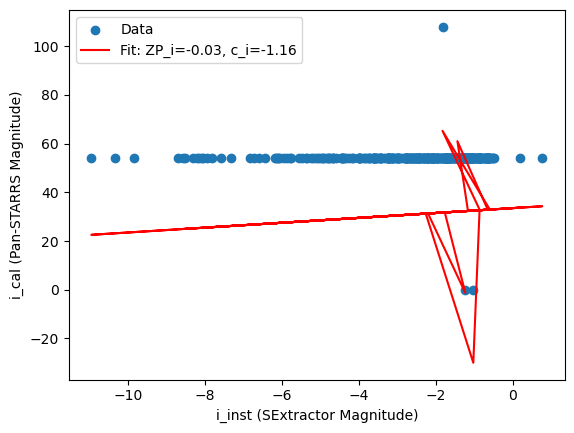

In [43]:
panstarrs_mags = psd['inTotal']
sextractor_mags = sec['MAG_AUTO'][:337]

panstarrs_r_mags = psd['rnTotal']
color_term = panstarrs_r_mags - panstarrs_mags


A = np.vstack([sextractor_mags, color_term, np.ones_like(sextractor_mags)]).T
coeffs, _, _, _ = np.linalg.lstsq(A, panstarrs_mags, rcond=None)
ZP_i, c_i, _ = coeffs

# Plot the results
plt.scatter(sextractor_mags, panstarrs_mags, label='Data')
plt.plot(sextractor_mags, ZP_i + c_i * color_term + sextractor_mags, label=f'Fit: ZP_i={ZP_i:.2f}, c_i={c_i:.2f}', color='red')
plt.xlabel('i_inst (SExtractor Magnitude)')
plt.ylabel('i_cal (Pan-STARRS Magnitude)')
plt.legend()
plt.show()